Code adapted from TensorFlow's "Image captioning with visual attention" article, specifically the "A Transformer decoder model section.
https://www.tensorflow.org/text/tutorials/image_captioning#a_transformer_decoder_model

In [219]:
import importlib
import string
import re

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from pycocotools.coco import COCO

# So we don't have to reload the notebook each time a change is made to dataset.py or model.py
import utils.model
importlib.reload(utils.model)
import utils.dataset
importlib.reload(utils.dataset)

from utils.model import TokenOutput, Captioner, GenerateText, SeqEmbedding, CausalSelfAttention, CrossAttention, FeedForward, DecoderLayer, standardize
from utils.dataset import setup_trainval_sets, load_dataset, load_image

In [220]:
np.random.seed(42)
tf.random.set_seed(42)

In [46]:
# Constants for notebook
TRAIN_DATASET_PATH = "./processed_dataset/train2014_full"
VAL_DATASET_PATH = "./processed_dataset/val2014_full"
TRAIN_ANNOTATIONS_PATH = "dataset/annotations_trainval2014/captions_train2014.json"
VAL_ANNOTATIONS_PATH = "dataset/annotations_trainval2014/captions_val2014.json"

BATCH_SIZE = 256
VOCABULARY_SIZE = 10000
IMAGE_SHAPE = (224, 224, 3)

In [47]:
coco_train = COCO(TRAIN_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


In [8]:
train_raw = setup_trainval_sets("train2014", coco_train)

I0000 00:00:1737891738.182346     864 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [9]:
for ex_path, ex_caption in train_raw.take(1):
    print("Image path:", ex_path.numpy())
    print("Caption:", ex_caption.numpy())

Image path: b'dataset/train2014/COCO_train2014_000000057870.jpg'
Caption: b'A restaurant has modern wooden tables and chairs.'


2025-01-26 12:42:20.368559: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
mobilenet = MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False, # Exclude the classification head
    weights='imagenet',
    pooling=None,
)

mobilenet.trainable=False

In [63]:
tokenizer = TextVectorization(
  max_tokens=VOCABULARY_SIZE,
  standardize=standardize,
  output_sequence_length=50,
  ragged=True
)

In [64]:
tokenizer.adapt(train_raw.map(lambda img_path, caption: caption).batch(1024))

In [65]:
tokenizer.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('a'),
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('on'),
 np.str_('of'),
 np.str_('the'),
 np.str_('in'),
 np.str_('with')]

In [112]:
tokenizer.vocabulary_size()

10000

In [66]:
tokenizer.get_config()

{'name': 'text_vectorization_2',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 10000,
 'standardize': <function utils.model.standardize(s)>,
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 50,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': True,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 10000}

In [15]:
tokenizer

<TextVectorization name=text_vectorization, built=False>

In [16]:
t = tokenizer([['a large wooden cat'], ['a table on a hill']])

In [67]:
# Setting up data for training
train_ds = load_dataset(TRAIN_DATASET_PATH)
val_ds = load_dataset(VAL_DATASET_PATH)

In [68]:
# Sanity check for data loading
train_ds.element_spec

for (inputs, end_token) in train_ds.take(1):
  (img, start_token) = inputs

print(img.shape)
print(start_token.shape)
print(end_token.shape)

print(start_token[0])
print(end_token[0])
print(img[0])

(256, 7, 7, 576)
(256, 22)
(256, 22)
tf.Tensor(
[  3   2 633 272 117  58   9   2 873   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(22,), dtype=int64)
tf.Tensor(
[  2 633 272 117  58   9   2 873   4   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(22,), dtype=int64)
tf.Tensor(
[[[-2.35861585e-01 -0.00000000e+00  2.88518882e+00 ... -0.00000000e+00
    3.71150875e+00 -0.00000000e+00]
  [ 2.72211909e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
    3.00443935e+00 -0.00000000e+00]
  [ 9.36598778e+00 -0.00000000e+00  6.09354615e-01 ... -0.00000000e+00
    1.00399280e+00 -0.00000000e+00]
  ...
  [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
   -3.64820182e-01 -0.00000000e+00]
  [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
   -0.00000000e+00 -0.00000000e+00]
  [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
   -0.00000000e+00 -0.00000000e+00]]

 [[-0.00000000e+00 -0.00000000e+00  2.795090

2025-01-26 13:22:05.465920: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [80]:
total_samples_train = tf.data.experimental.cardinality(train_ds).numpy()
total_samples_train # of batch 256

np.int64(1618)

In [81]:
total_samples_val = tf.data.experimental.cardinality(val_ds).numpy()
total_samples_val # of batch 256

np.int64(792)

In [221]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 1618/1618 [11:06<00:00,  2.43it/s]


Uniform entropy: 9.21
Marginal entropy: 5.41


In [32]:
model = Captioner(
    tokenizer, 
    feature_extractor=mobilenet, 
    output_layer=output_layer,
    units=256, 
    dropout_rate=0.5, 
    num_layers=2, 
    num_heads=2
)

In [17]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path, IMAGE_SHAPE)

In [18]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)
  print("--------")

I0000 00:00:1737807364.478120     961 cuda_dnn.cc:529] Loaded cuDNN version 90600
/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'captioner', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


a a a a a a a a a a a a a a a a a a a a a a
--------

--------
and in sigh stop a clean and and is track young large to park standing in
--------


In [222]:
@tf.keras.utils.register_keras_serializable()
def masked_loss(labels, preds):
  labels = tf.cast(labels, tf.int32)  # Ensure labels are integers
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

@tf.keras.utils.register_keras_serializable()
def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

In [22]:
callbacks = [
    GenerateText(IMAGE_SHAPE),
    EarlyStopping(patience=5, restore_best_weights=True)
]

In [35]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss=masked_loss, metrics=[masked_acc])

In [36]:
# 1 epoch takes about 16~ minutes (13~ minutes training and 3~ minutes validation)
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=100,
#     callbacks=callbacks
# )

# total number of train samples = 1618 and total number of val samples = 792
# 16 * 100 = 1600 (little less than entire training set) and 16 * 48 = 768 (little less than entire val set) to prevent errors
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=16,
    steps_per_epoch=100,
    validation_steps=48,
    callbacks=callbacks
)

Epoch 1/16


/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'captioner_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - loss: 4.5600 - masked_acc: 0.2483

a man is riding a surfboard on a wave
a person is in the air on a snow
a surfer white is getting to shade while skiers a surfboard

100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 657ms/step - loss: 4.5557 - masked_acc: 0.2488 - val_loss: 3.6519 - val_masked_acc: 0.3507
Epoch 2/16
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - loss: 3.5784 - masked_acc: 0.3603

a person on a surfboard in the ocean
a person on a surfboard on a surfboard
this is a white painted brush covered with several kicking water with arm

100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 629ms/step - loss: 3.5778 - masked_acc: 0.3604 - val_loss: 3.4223 - val_masked_acc: 0.3798
Epoch 3/16
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - loss: 3.3811 - masked_acc: 0.3851

a man is on a surfboard in the water
a person riding a wave on a wave in the water
a person with the birds is bends of alongside the mountains

100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 638ms/step - loss: 3.3807 - ma

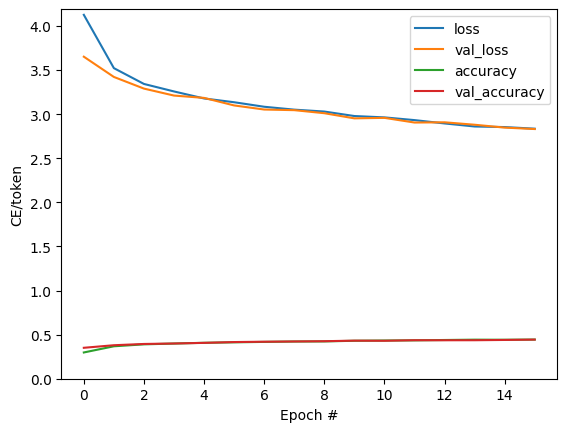

In [37]:
# Plotting
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()



### Hyper-parameter tuning and model training

In [84]:
def build_model(hp):
    model = Captioner(
        tokenizer=tokenizer, 
        feature_extractor=mobilenet, 
        output_layer=output_layer,
        units=256,
        dropout_rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1),
        num_layers=hp.Int('num_layers', min_value=1, max_value=5, step=1),
        num_heads=hp.Int('num_heads', min_value=1, max_value=5, step=1)
    )

    optimizer_name = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.00001, 0.0001, 0.001, 0.01]))
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=hp.Choice('learning_rate', values=[0.00001, 0.0001, 0.001, 0.01]), momentum=0.9)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp.Choice('learning_rate', values=[0.00001, 0.0001, 0.001, 0.01]))

    input_shape = ((None, 7, 7, 576), (None, None))  # Example input shapes
    model.build(input_shape) # Needed to add this line, some trials would fail otherwise.

    model.compile(
        optimizer=optimizer,
        loss=masked_loss,
        metrics=[masked_acc]
    )
    return model

In [85]:
callbacks = [
    GenerateText(IMAGE_SHAPE),
    EarlyStopping(patience=3, restore_best_weights=True)
]

In [86]:
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_masked_acc", direction="max"),
    max_epochs=16,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='captioner_tuning'
)

/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'captioner_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [87]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=16,
    steps_per_epoch=100,
    validation_steps=48,
    callbacks=callbacks
)

Trial 30 Complete [00h 13m 29s]
val_masked_acc: 0.3926910161972046

Best val_masked_acc So Far: 0.46603575348854065
Total elapsed time: 02h 48m 27s


In [88]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [117]:
best_model = tuner.get_best_models()[0]

/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'captioner', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.save_weights("trained_model/checkpoint_weights.weights.h5")

In [115]:
for hp_name, hp_value in best_hps.values.items():
    print(f"{hp_name}: {hp_value}")

dropout_rate: 0.2
num_layers: 2
num_heads: 2
optimizer: adam
learning_rate: 0.001
tuner/epochs: 16
tuner/initial_epoch: 6
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020


In [27]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path, IMAGE_SHAPE)

In [131]:
for t in (0.0, 0.5, 1.0):
  result = best_model.simple_gen(image, temperature=t)
  print(result)
  print("--------")

a surfer is riding a wave in the ocean
--------
a surfer is surfing on the ocean
--------
a man is surfboard caught in on a wave in the ocean
--------


In [224]:
new_best_model = Captioner(
    tokenizer, 
    feature_extractor=mobilenet, 
    output_layer=output_layer,
    units=256, 
    dropout_rate=0.2, 
    num_layers=2, 
    num_heads=2
)

new_best_model.compile(optimizer=Adam(learning_rate=0.001), loss=masked_loss, metrics=[masked_acc])

input_shape = ((None, 7, 7, 576), (None, None))  # Example input shapes
new_best_model.build(input_shape)

/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'captioner_36', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [227]:
new_best_model.load_weights("trained_model/checkpoint_weights.weights.h5")

In [228]:
for t in (0.0, 0.5, 1.0):
  # best_result = best_model.simple_gen(image, temperature=t)
  new_best_result = new_best_model.simple_gen(image, temperature=t)
  # print("Best_model.result = ", best_result)
  print("--------")
  print("New_best_model.result = ", new_best_result)
  print("--------")


--------
New_best_model.result =  a surfer is riding a wave in the ocean
--------
--------
New_best_model.result =  a man is surfing on a wave in the ocean
--------
--------
New_best_model.result =  a surfboard is of a man riding a wave
--------


In [229]:
new_best_model.save("trained_model/model_checkpoint.keras")

In [223]:
@tf.keras.utils.register_keras_serializable()
def standardize(s):
    s = tf.strings.lower(s) # Lowercase
    s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '') # Remove puncuation
    s = tf.strings.join(['[START]', s, '[END]'], separator=' ') # Add [START] and [END] tokens to the text
    return s

In [233]:
# Spent 2 days on this, I can't figure it out :(

loaded_model = load_model(
    'trained_model/model_checkpoint.keras',
    custom_objects={
        'SeqEmbedding': SeqEmbedding,
        'CausalSelfAttention': CausalSelfAttention,
        'CrossAttention': CrossAttention,
        'FeedForward': FeedForward,
        'DecoderLayer': DecoderLayer,
        'TokenOutput': TokenOutput,
        'Captioner': Captioner,
        'masked_loss': masked_loss,
        'masked_acc': masked_acc
    }
)

/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'token_output_26', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:730: UserWarning: Model 'captioner_40' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  

ValueError: A total of 2 objects could not be loaded. Example error message for object <TextVectorization name=text_vectorization_41, built=False>:

expected str, bytes or os.PathLike object, not NoneType

List of objects that could not be loaded:
[<TextVectorization name=text_vectorization_41, built=False>, <StringLookup name=string_lookup_126, built=False>]